In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

google_gemma-3-1b-pt found 14 experiments
Qwen_Qwen3-0.6B found 10 experiments


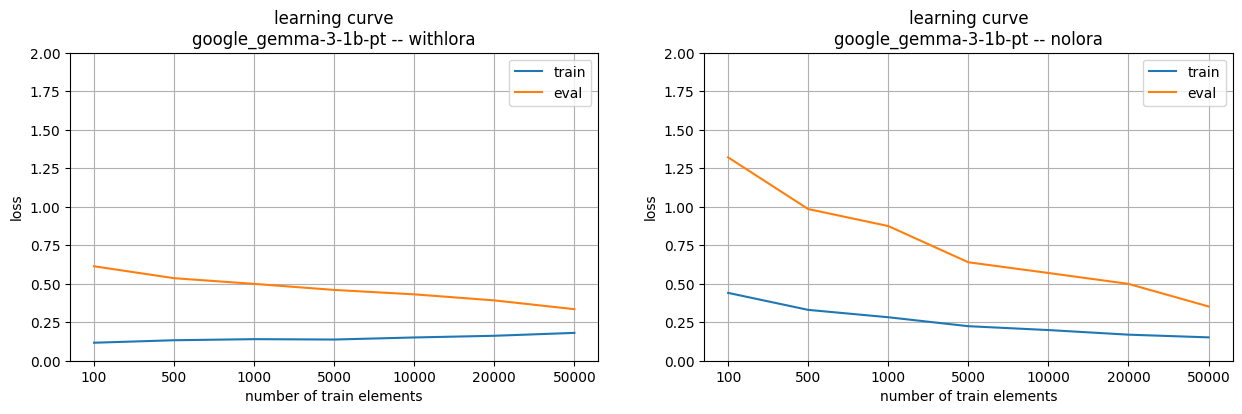

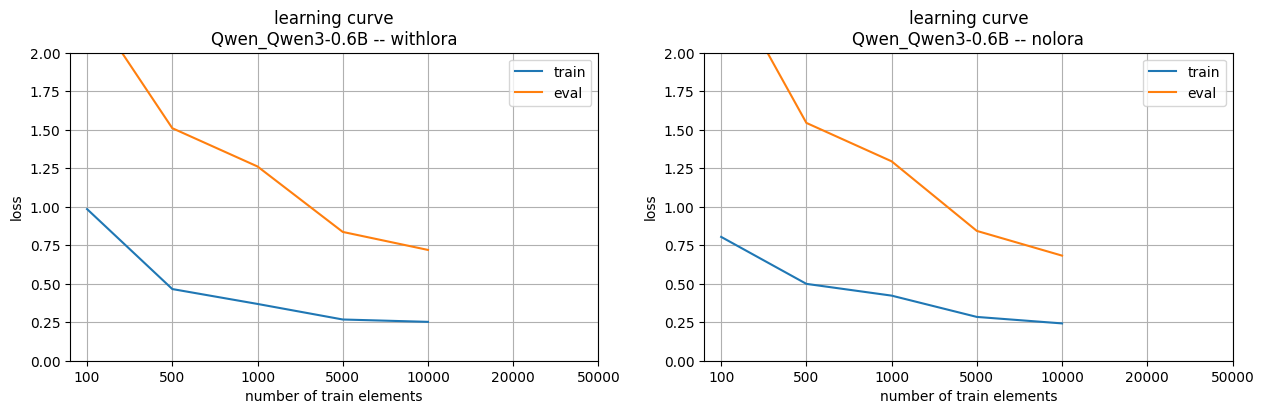

In [240]:
models = ['google_gemma-3-1b-pt', 'Qwen_Qwen3-0.6B']

plot_loss_curves = False

for model in models:

    # read all parquet files with training histories
    rs = glob(f'results/{model}*.parquet')
    
    r = []
    for ri in rs:
        rr = ri.split('/')[-1]
        model, lora, training_samples, _, _ = rr.split('--')
        n_training_samples  = int(training_samples.split('_')[-1])
        s = pd.read_parquet(ri)
        r.append({'file': ri, 'model': model, 'lora': lora, 'n_training_samples': n_training_samples})
    
    r = pd.DataFrame(r).sort_values(['lora', 'n_training_samples'])
    
    print (f'{model} found {len(r)} experiments')


    
    if plot_loss_curves:
        fig,axs = plt.subplots(2, len(r)//2 + len(r)%2, figsize=[6*len(r)//2, 8])
        axs = axs.flatten()
    
    rs = []

    # get the min train and eval loss in each training, while plotting loss curves
    for i in range(len(r)):
        if i>=len(r):
            continue
        ri = r.iloc[i]
        s = pd.read_parquet(ri.file)
        z = s[['loss', 'eval_loss','step']].ffill().set_index('step')
        min_eval_loss = np.nanmin(z.eval_loss.values)
        min_train_loss = np.nanmin(z.loss.values)

        if plot_loss_curves:
            ax = axs[i]
            z.plot(ax=ax)
            ax.set_title(f'{model} {ri.lora}, training samples {ri.n_training_samples}\nmin losses: train {min_train_loss:.3f} eval {min_eval_loss:.3f}')
            ax.grid()
            ax.set_ylim(0,2)
        rs.append({'n_training_samples': ri.n_training_samples, 'eval': min_eval_loss, 'train': min_train_loss, 'lora': ri.lora})    
    rs = pd.DataFrame(rs)

    # append mising values as nan
    nset = [100,500,1000,5000,10000,20000,50000]
    ra = []
    for n in nset:
        if len(rs[(rs.n_training_samples==n) & (rs.lora=='nolora')]) == 0:
            ra.append({'n_training_samples': n, 'eval': np.nan, 'train': np.nan, 'lora': 'nolora'})
        if len(rs[(rs.n_training_samples==n) & (rs.lora=='withlora')]) == 0:
            ra.append({'n_training_samples': n, 'eval': np.nan, 'train': np.nan, 'lora': 'withlora'})
    rs = pd.concat((rs, pd.DataFrame(ra))).sort_values(['lora', 'n_training_samples'])    


    
    if plot_loss_curves:
        fig.tight_layout()

    # plot learning curves
    fig,axs = plt.subplots(1,2, figsize=(15,4))
    axs = axs.flatten()
    
    for ax,l in zip(axs, ['withlora', 'nolora']):
    
        rsi = rs[rs.lora==l].sort_values('n_training_samples')
        rsi.index = [str(i) for i in rsi.n_training_samples]
        rsi = rsi[['train', 'eval']]
        rsi.plot(ax=ax)
        ax.set_xticks(range(len(nset)), nset)
        ax.grid()
        ax.set_ylim(0,2)
        ax.set_title(f'learning curve\n{model} -- {l}')
        ax.set_xlabel('number of train elements')
        ax.set_ylabel('loss')
